# DSCI 619 Deep Learning
# Week 6: Build a Simple Recurrent Sequence-to-Sequence Model

**Objectives**

After you complete this module, students will be able to:


+ Use the encoder to encode the input texts
+ Apply the decoder to predict the  next token
+ Understand the encoder-decoder architecture
+ Choose the loss function for the decoder
+ Train the sequence to sequence model
+ Predict the output sequence token

Sequence to sequence model is a family of deep learning approaches used for natural language processing such as language translation etc. We will cover a simple recurrent sequence to sequence model. First, we cover the encoder.  Next, we will cover the decoder. Third, we will show how to use both encoder and decoder to perform language translation.  

**Readings**

+ Sequence to Sequence Learning (https://d2l.ai/chapter_recurrent-modern/seq2seq.html)
+ A ten-minute introduction to sequence-to-sequence learning in Keras (RNN)(https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)
+ Character-level recurrent sequence-to-sequence model (https://keras.io/examples/nlp/lstm_seq2seq/)



# Week 6: Build a Simple Recurrent Sequence-to-sequence Model

## Short Introduction to Recurrent Sequence to Sequence Model

It is well known that Google translate (https://translate.google.com/) is a very powerful tool to translate a text from one language into another. For example, if we enter the following text in English in the left textbox:

<center> It's a beautiful day! </center>

We choose the target language as Spanish. Then, Google translate produces the following output:

<center> ¡Es un hermoso día! </center>


It is based on the neural machine translation system. (see https://arxiv.org/abs/1609.08144). These models are based on RNN and LSTM etc. The sequence to sequence model converts sequences from one language, such as in English to sequences in another langue, such as in Spanish.

The sequence to sequence model typically has an encoder and a decoder. This RNN encoder-decoder takes a sequence, such as English text, as input and generates another sequence, such as Spanish text,  as output. 

We will build a simple recurrent sequence to sequence model. This project is taken from Keras' official code examples. You can find it at Kera's official website (https://keras.io/examples/nlp/lstm_seq2seq/). 

## Import the library and Fix the Seeds

First, we import the libraries we need. Then we fix the seeds, and we can reproduce the results.

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Fix the seeds
# https://stackoverflow.com/questions/1805265/how-to-fix-value-produced-by-random
SEED = 101
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data: Tab-delimited Bilingual Sentence Pairs

Our data is taken from the Tatoeba Project (https://tatoeba.org/eng). It provides more than eighty Tab-delimited Bilingual Sentence Pairs (http://www.manythings.org/anki/). The data files have the following format:

<center> English + TAB + The Other Language + TAB + Attribution </center>

For example:

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)

Go.	Marche.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)


We build a model to translate simple English to Spanish.


## Clean and Preprocessing Data

### Set the Hyperparameters

In [2]:
# Set the batch size
batch_size = 64  
# Set the epochs number
epochs = 100  
# Latent dimensionality of the encoding space.
latent_dim = 256  
# Number of samples to use.
num_samples = 10000  
# Data file 
data_path = "C:/Users/liuyu/OneDrive/OneDrive - Maryville University/DSCI 619/Modules/WK6/data/eng-spa.txt"

### Separate Input Texts and Target Texts

Since each row contains both the input texts and target texts, we need to separate them into inputs and targets. We also need to obtain the unique input characters and target characters. Our model will use it to produce predictions for the next character in our model. 

In [3]:
# Obtain the features (input) and labels (target)
input_texts = []
target_texts = []
# Unique characters in the inputs and targets
input_characters = set()
target_characters = set()
# Load the data into memory
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
# Process line by line
for line in lines[: min(num_samples, len(lines) - 1)]:
    # Data format English + TAB + The Other Language + TAB + Attribution
    # It returns: English, The other language, and Attribution, which is discarded
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    # Get the unique char from the input texts
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    # Get the unique char from the target texts
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)



Next, we sort the input characters and output characters. We then get the length of the encoder tokens and decoder tokens. Finally, we figure out the maximum size of the input texts and output texts.

In [4]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print(f'Number of samples:= {len(input_texts)}')
print(f"Number of unique input tokens: = {num_encoder_tokens}")
print(f"Number of unique output tokens: = {num_decoder_tokens}")
print(f"Max sequence length for inputs: = {max_encoder_seq_length}")
print(f"Max sequence length for outputs: = {max_decoder_seq_length}")



Number of samples:= 10000
Number of unique input tokens: = 69
Number of unique output tokens: = 84
Max sequence length for inputs: = 16
Max sequence length for outputs: = 78


### Map Input and Target Characters to Numbers

Machine learning and deep learning models can only handle numerical data. Therefore, we need to convert the input and target characters to numerical values. A simple mapping of characters to indices is used. The mapping is stored in a dictionary. The key is the char, and the value is its index. It is very easy to search by the key. 


In [5]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])



In [6]:
input_token_index

{' ': 0,
 '!': 1,
 '$': 2,
 "'": 3,
 ',': 4,
 '-': 5,
 '.': 6,
 '0': 7,
 '1': 8,
 '2': 9,
 '3': 10,
 '4': 11,
 '5': 12,
 '6': 13,
 '7': 14,
 '8': 15,
 '9': 16,
 ':': 17,
 '?': 18,
 'A': 19,
 'B': 20,
 'C': 21,
 'D': 22,
 'E': 23,
 'F': 24,
 'G': 25,
 'H': 26,
 'I': 27,
 'J': 28,
 'K': 29,
 'L': 30,
 'M': 31,
 'N': 32,
 'O': 33,
 'P': 34,
 'Q': 35,
 'R': 36,
 'S': 37,
 'T': 38,
 'U': 39,
 'V': 40,
 'W': 41,
 'Y': 42,
 'a': 43,
 'b': 44,
 'c': 45,
 'd': 46,
 'e': 47,
 'f': 48,
 'g': 49,
 'h': 50,
 'i': 51,
 'j': 52,
 'k': 53,
 'l': 54,
 'm': 55,
 'n': 56,
 'o': 57,
 'p': 58,
 'q': 59,
 'r': 60,
 's': 61,
 't': 62,
 'u': 63,
 'v': 64,
 'w': 65,
 'x': 66,
 'y': 67,
 'z': 68}

In [7]:
target_token_index

{'\t': 0,
 '\n': 1,
 ' ': 2,
 '!': 3,
 '"': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '0': 9,
 '1': 10,
 '2': 11,
 '3': 12,
 '4': 13,
 '5': 14,
 '6': 15,
 '7': 16,
 '8': 17,
 ':': 18,
 '?': 19,
 'A': 20,
 'B': 21,
 'C': 22,
 'D': 23,
 'E': 24,
 'F': 25,
 'G': 26,
 'H': 27,
 'I': 28,
 'J': 29,
 'L': 30,
 'M': 31,
 'N': 32,
 'O': 33,
 'P': 34,
 'Q': 35,
 'R': 36,
 'S': 37,
 'T': 38,
 'U': 39,
 'V': 40,
 'W': 41,
 'Y': 42,
 'a': 43,
 'b': 44,
 'c': 45,
 'd': 46,
 'e': 47,
 'f': 48,
 'g': 49,
 'h': 50,
 'i': 51,
 'j': 52,
 'k': 53,
 'l': 54,
 'm': 55,
 'n': 56,
 'o': 57,
 'p': 58,
 'q': 59,
 'r': 60,
 's': 61,
 't': 62,
 'u': 63,
 'v': 64,
 'w': 65,
 'x': 66,
 'y': 67,
 'z': 68,
 '¡': 69,
 '«': 70,
 '»': 71,
 '¿': 72,
 'Á': 73,
 'É': 74,
 'Ó': 75,
 'Ú': 76,
 'á': 77,
 'é': 78,
 'í': 79,
 'ñ': 80,
 'ó': 81,
 'ú': 82,
 'ü': 83}

### Convert Input and Target Texts to Numerical Values

We need to convert the features (input texts) and labels( target texts) to numerical values. They are converted to  3-dimensional matrix:
+ The first dimension denotes the number of samples
+ The second dimension shows the maximum length of the input texts or output texts
+ The third dimension denotes the number of unique characters

Each element of the matrix has only two values, 0 or 1. 
+ 0 means the corresponding character doesn't show up in the texts.
+ 1 means the corresponding character shows up in the texts. 


In [8]:
# Initialize the 3 D matrix
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

# Convert the input texts and target texts to numerical values
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    # Convert input texts to numerical values
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    # Pad the remaining using space that is mapped to 1
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    # Convert target texts to numerical values
    for t, char in enumerate(target_text):
        # decoder input is used to forecast decoder target
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    # Pad the remaining using space that is mapped to 1
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Let's look at the 3D matrices:

In [9]:
encoder_input_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [10]:
decoder_input_data

array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0.

In [11]:
decoder_target_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0.

## Build the Model

This RNN model has two key layers. 
+ A LSTM encoder layer: it processes the input texts/sequence and returns its own internal state.  The outputs of the encoder is discarded.The hidden states will be used as the "context" of the decoder in the next step.
+ A LSTM decoder layer: it is trained to predict the next characters of the target sequence, given previous characters of the target sequence. Specifically, it is trained to turn the target sequences into the same sequences but offset by one timestep in the future, a training process called "teacher forcing" in this context. Importantly, the encoder uses as initial state the state vectors from the encoder, which is how the decoder obtains information about what it is supposed to generate. Effectively, the decoder learns to generate targets[t+1...] given targets[...t], conditioned on the input sequence.

Source: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [12]:
## Begin Define the encoder layes
# Define an input sequence
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
# Define the LSTM which will return the hidden states
encoder = keras.layers.LSTM(latent_dim, return_state=True)
# Apply LSTM and return the ouputs and hidden states
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# Discard the outputs and only keep the states.
encoder_states = [state_h, state_c]
## End Define the encoder layes


## Begin Define the decoder layes
# Define the decoder inputs
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
# Set up the decoder, using `encoder_states` as initial state.
# Kee the outputs and discard the hidden states
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# Forecast he decoder outputs using a classifier based on the decoder outputs
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)
## End Define the decoder layes

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Configure the Model

We forecast the decoder characters. It is a multiclass classification problem. We configure the model by specifying the optimizer and the loss function as categorical cross-entropy.

In [13]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)


## Train the Model

We train the model by providing the inputs that have two items of encoder_input_data and decoder_input_data. We take advantage of early stopping during the training. 

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping


In [14]:
from tensorflow.keras.callbacks import EarlyStopping
# Setup early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    min_delta=0.001, 
    mode='max'
)
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[early_stopping],
)
# Save model
model.save("s2s")

Epoch 1/100
125/125 [==============================] - 24s 195ms/step - loss: 0.8095 - accuracy: 0.8077 - val_loss: 0.7966 - val_accuracy: 0.7936
Epoch 2/100
125/125 [==============================] - 24s 188ms/step - loss: 0.5767 - accuracy: 0.8438 - val_loss: 0.5970 - val_accuracy: 0.8330
Epoch 3/100
125/125 [==============================] - 24s 191ms/step - loss: 0.4824 - accuracy: 0.8647 - val_loss: 0.5308 - val_accuracy: 0.8428
Epoch 4/100
125/125 [==============================] - 25s 199ms/step - loss: 0.4405 - accuracy: 0.8712 - val_loss: 0.5212 - val_accuracy: 0.8474
Epoch 5/100
125/125 [==============================] - 25s 196ms/step - loss: 0.4025 - accuracy: 0.8803 - val_loss: 0.4864 - val_accuracy: 0.8539
Epoch 6/100
125/125 [==============================] - 25s 196ms/step - loss: 0.3788 - accuracy: 0.8860 - val_loss: 0.4437 - val_accuracy: 0.8653
Epoch 7/100
125/125 [==============================] - 25s 196ms/step - loss: 0.3580 - accuracy: 0.8917 - val_loss: 0.4383 -

## Model Diagnostics
Let's look at the in-sample fit and out-of-sample fit.

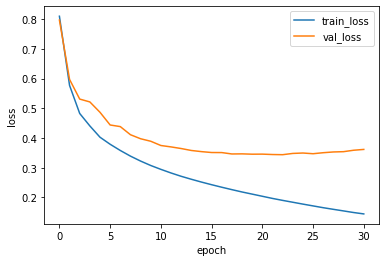

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

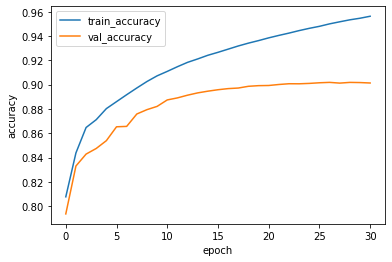

In [16]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

## Run Inference

When we want to decode unknown input sequences, we go through a slightly different process using the encoder and decoder by providing the inputs and corresponding states. The states contain the context info of the texts.

We need to identify the layers to use in the inference model. Let's look at the model architecture. 

In [17]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 69)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 84)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 333824      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  349184      input_2[0][0]                    
                                                                 lstm[0][1]            

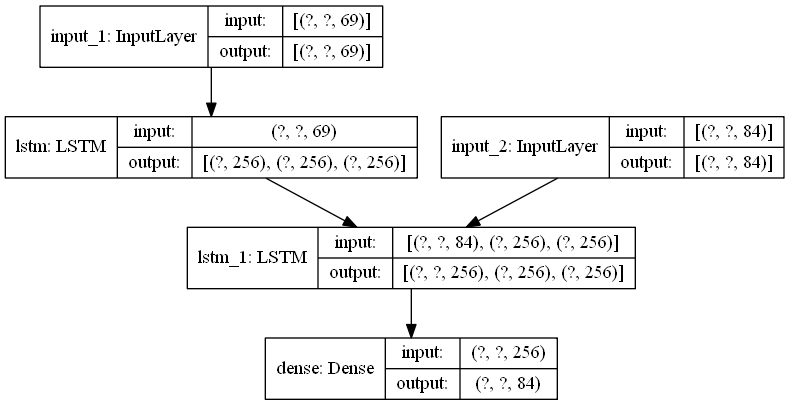

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

It is easy to see that it has five layers:
+ two input layers
+ two LSTM layers
+ one classifier layer

In [19]:
model.layers

In [20]:
model.input

[<tf.Tensor 'input_1:0' shape=(None, None, 69) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(None, None, 84) dtype=float32>]

### Create the Inference Model

The inference model is very similar to the previous model. The main differences are in the hidden state's info.

In [21]:
# Define the inference models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

# Set up the encoder model
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

# Set up the decoder layer
decoder_inputs = model.input[1]  # input_2
# Set up the inputs for the hidden states
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)

# The decoder model with inputs and states inputs with the context info
# The decoder model with outputs = decoder outputs and states with the context info
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)



### Forecast the Target Texts

Next, we predict the target texts using the inference model. First, we need to have an inverse transformation to map the indices to the corresponding characters.


In [22]:
# Map the indicesto the corresponding characters
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


Next, we need to map the input texts to the target texts by performing the following tasks:

+ Encode the input texts as state vectors
+ Generate an empty target text of length 1
+ Loop over the sequence
    + Predict the output based on the target sequence and hidden states
    + Update the target sequence
    + Update the hidden sates 

In [23]:

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        # forcast the outputs and hidden states
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Get the indices of the non-empty character
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # Map the indices to the corresponding character
        sampled_char = reverse_target_char_index[sampled_token_index]
        # Concatenate the predicted char
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [24]:
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Vete a la mana.

-
Input sentence: Go.
Decoded sentence: Vete a la mana.

-
Input sentence: Go.
Decoded sentence: Vete a la mana.

-
Input sentence: Go.
Decoded sentence: Vete a la mana.

-
Input sentence: Hi.
Decoded sentence: Hole.

-
Input sentence: Run!
Decoded sentence: ¡Corre!

-
Input sentence: Run!
Decoded sentence: ¡Corre!

-
Input sentence: Run!
Decoded sentence: ¡Corre!

-
Input sentence: Run!
Decoded sentence: ¡Corre!

-
Input sentence: Run.
Decoded sentence: Sé tante.



### Forecast on the New Inputs


In [25]:

New_input_text = "great"
encoder_input_data = np.zeros(
    (1, max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)

for t, char in enumerate(New_input_text):
    encoder_input_data[0, t, input_token_index[char]] = 1.0
    # Pad the remaining using space that is mapped to 1
    encoder_input_data[0, t + 1 :, input_token_index[" "]] = 1.0


In [26]:
decoded_sentence = decode_sequence(encoder_input_data)
print(f"The input sentence: {New_input_text}, the decoded sentence: ={decoded_sentence}")


The input sentence: great, the decoded sentence: =¿Vine eso?



# Summary

+ The sequence to sequence model typically contains an encoder and a decoder.
+ We need to add a classifier in the decoder to forecast the next token.
+ We can use multilayer RNNs to implement the encoder and the decoder.
+ We need to design the inference model to forecast tokens instead of using the original model.
+ We learn how to train and evaluate the sequence to sequence model. 